# Inference - Classification, BBox, Angle

## Parameters

In [10]:
# test 0: Full unit circle, test 1: Right half plane, test 2: Regular angle
test = 0
img_list_file = 'list_of_img_in_val_set_18-03.csv'
place_to_store_results = 'Evaluations/'
path_img_folder = '../../03 Data/Simple Dataset/'
accept_BB_threshold = 0.9

model_folder = "./snapshots/"
model_name = "Full_Unit_Circle_SmoothL1_resnet50_csv_25.h5"

## Imports

In [2]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from numpy import genfromtxt
import time
import json
import copy

# use this to change which GPU to use
gpu = 0
# set the modified tf session as backend in keras  
#setup_gpu(gpu)  #NOTICE: enable when using paperspace server!!

Using TensorFlow backend.


## Functions

In [3]:
def convert_rect_to_point(rect):
    x = rect[0]
    y = rect[1]
    w = rect[2]
    h = rect[3]
    x1 = x
    y1 = y
    x2 = x + w
    y2 = y + h
    
    return (x1, y1, x2, y2)

def read_annotations_from_json(img_name):
    with open(path_img_folder + img_name.strip('.png') + '.json') as json_file:
        data = json.load(json_file)
        shapes_list = data['shapes']
        bbox_list = []
        angle_list = []
        for annotation in shapes_list: 
            rect = cv2.boundingRect(np.float32(annotation['points']))
            rot_rect = cv2.minAreaRect(np.float32(annotation['points']))
            if rot_rect[-2][0] < rot_rect[-2][1]:
                rot_rect = (rot_rect[0],(rot_rect[-2][1],rot_rect[-2][0]),rot_rect[-1]+90)
            # make sure that no angle is above 90 or below -90
            if rot_rect[-1] > 90:
                rot_rect = (rot_rect[0],rot_rect[1],rot_rect[-1]-180)
            if rot_rect[-1] < -90:
                rot_rect = (rot_rect[0],rot_rect[1],rot_rect[-1]+180)
            angle_list.append(rot_rect[-1]/180*np.pi)
            bbox_list.append(convert_rect_to_point(rect))
    return bbox_list, angle_list; 


def max_val(val1, val2):
    if val1 > val2:
        return val1
    else:
        return val2
    
def min_val(val1, val2):
    if val1 > val2:
        return val2
    else:
        return val1
    
    
def filter_bounding_boxes(bounding_boxes, scores, angles):
    list_of_BB = []
    list_of_angles = []
    for box, score, angle in zip(bounding_boxes, scores, angles):
        if score < accept_BB_threshold: 
            break
        list_of_angles.append(angle)
        list_of_BB.append(box)
    return list_of_BB, list_of_angles

def format_angle(angles, test):
    formatted_angles = []
    if test == 0:
        for angle in angles:
            print(angle[1])
            formatted_angles.append(np.arctan2(angle[1],angle[0])/2)
    elif test == 1:
        for angle in angles:
            formatted_angles.append(np.arctan2(angle[1],angle[0]))
    elif test == 2:
        formatted_angles.append(angle)
    return formatted_angles 

def area(BB):
    width = abs(BB[0] - BB[2])
    height = abs(BB[1] - BB[3])
    return height * width

def intersection(BB1, BB2):
    # find coordiantes of intersection rectangle 
    (x1, y1, x2, y2) = BB1
    (x3, y3, x4, y4) = BB2
    if x1 > x4 or x3 > x2 or y3 > y2 or y1 > y4:
        return 0
    x5 = max_val(x1, x3);
    y5 = max_val(y1, y3);
    x6 = min_val(x2, x4);
    y6 = min_val(y2, y4);  
    BB = (x5, y5, x6, y6)
    # TODO: check if no intersection exists
    return area(BB)
    
def union(BB1, BB2): 
    return area(BB1) + area(BB2) - intersection(BB1, BB2)

def IOU(BB1, BB2):
    return intersection(BB1, BB2)/union(BB1, BB2)

def evaluate_predictions(bbox_annotations, angle_annotations, bbox_preds, angle_preds, IOU_thres):
    bbox_predictions = copy.deepcopy(bbox_preds)
    angle_predictions = copy.deepcopy(angle_preds)
    false_neg = 0
    error_list = []
    for idx, annotation in enumerate(bbox_annotations): 
        #annotation = convert_rect_to_point(anno)
        max_IOU = 0
        for i in range(len(bbox_predictions)): 
            #print('Annotation: ', annotation)
            #print('pred candidate: ', predictions[i])
            if intersection(annotation, bbox_predictions[i]) > 0: #convert_rect_to_point only for tests
                IOU = intersection(annotation, bbox_predictions[i])/union(annotation, bbox_predictions[i])
                #print(IOU)  
                if(IOU > max_IOU):
                    max_IOU_index = i
                    max_IOU = IOU
        if max_IOU > IOU_thres:
            # remove prediction from list
            bbox_predictions.pop(max_IOU_index)
            error_list.append(angle_predictions[max_IOU_index] - angle_annotations[idx])
            angle_predictions.pop(max_IOU_index)
        else:
            false_neg = false_neg + 1
    
    false_pos = len(bbox_predictions)
    true_pos = len(bbox_preds) - len(bbox_predictions)
    return (false_neg, false_pos, true_pos), error_list 

def draw_vector(img, angle_in, box, test):
    if test == 0:
        length = np.linalg.norm([angle_in[0],angle_in[1]])*25
        angle = np.arctan2(angle_in[1],angle_in[0])/2
    elif test == 1:
        length = np.linalg.norm([angle_in[0],angle_in[1]])*25
        angle = np.arctan2(angle_in[1],angle_in[0])
    elif test == 2:
        legnth = 25
        angle = angle_in
    return _draw_vector(img, angle, length, box)
        
    length = np.linalg.norm([x,y])*25
    angle = np.arctan2(y,x)
    angle = angle/2
    center_x = (box[0]+box[2])/2
    center_y = (box[1]+box[3])/2
    pt1_x = -length*np.cos(angle)+center_x
    pt1_y = -length*np.sin(angle)+center_y
    pt2_x = length*np.cos(angle)+center_x
    pt2_y = length*np.sin(angle)+center_y
    cv2.line(img, (int(pt1_x),int(pt1_y)), (int(pt2_x), int(pt2_y)), color = (0, 255,255), thickness = 2, lineType = 2)
    return

def _draw_vector(img, angle, length, box):
    center_x = (box[0]+box[2])/2
    center_y = (box[1]+box[3])/2
    pt1_x = -length*np.cos(angle)+center_x
    pt1_y = -length*np.sin(angle)+center_y
    pt2_x = length*np.cos(angle)+center_x
    pt2_y = length*np.sin(angle)+center_y
    cv2.line(img, (int(pt1_x),int(pt1_y)), (int(pt2_x), int(pt2_y)), color = (0, 255,255), thickness = 2, lineType = 2)
    return

## Setup Model

In [4]:
# import model
model_path = os.path.join(model_folder, model_name);
model = models.load_model(model_path, backbone_name='resnet50');

# If model is not converted to inference model, use line below: 
model = models.convert_model(model);

# Mapping of model output and classes
labels_to_names = {0: 'Brick'};

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

## Predictions

In [ ]:
# Definition of new filter predictions function
def associate_predictions(bbox_preds, bbox_annots, thresh):
    annotation_idx = []
    bbox_verdict = []
    for bbox_pred in bbox_preds:
        max_IOU = 0
        associate_annot_idx = 0
        for idx, bbox_annot in enumerate(bbox_annots):
            if IOU(bbox_pred,bbox_annot) > max_IOU:
                max_IOU = IOU(bbox_pred,bbox_annot)
                associate_annot_idx = idx
        annotation_idx.append(idx)
        if max_IOU > thresh:
            bbox_verdict.append(1) # 1 means true positive
        else:
            bbox_verdict.append(0) # 0 means false positive
    return annotation_idx, bbox_verdict

In [13]:
# import data
file = open(img_list_file)
file_paths = list(file)  

file_paths = file_paths[10:25]

bbox_prediction_list = [] 
angle_prediction_list = []

bbox_annotation_list = []
angle_annotation_list = []

alpha = 0.5

for path in file_paths:
    image = read_image_bgr(path_img_folder + path.strip('\n'))

    # create copy to draw on 
    draw = image.copy()
    draw2 = image.copy()
    #draw = cv2.cvtColor(draw, cv2.COLhttp://cocodataset.org/#detection-evalOR_BGR2RGB)
    
    # preprocess image 
    # TODOD: check if preprocess_image convert the image to RGB format
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image 
    boxes, scores, labels, angles = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    
    
    # print detections
    for box, score, label, angle in zip(boxes[0], scores[0], labels[0], angles[0]):
        # scores are sorted so we can break
        if score < accept_BB_threshold:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)
        draw_vector(draw, angle, box, test)
        draw_caption(draw2, b, caption)
        draw_vector(draw2, angle, box, test)
    
    cv2.addWeighted(draw, alpha, draw2, 1 - alpha,0, draw)
    # save image 
    cv2.imwrite(place_to_store_results + path.strip('\n'), draw)
    
    # load json file containing annotations
    bbox, angle = read_annotations_from_json(path.strip('\n'))
    bbox_annotation_list.append(bbox)
    angle_annotation_list.append(angle)
    
    # remove bounding boxes with a classification score below accept_BB_threshold. 
    bbox, angle = filter_bounding_boxes(boxes[0], scores[0], angles[0])
    bbox_prediction_list.append(bbox)
    angle_prediction_list.append(format_angle(angle,test))
    
#angle_prediction_list = format_angle(angle_prediction_list, test)

0.15895371
0.12472123
0.15786192
0.4198699
0.39924535
0.06604092
0.17044023
0.27396604
0.21502204
0.2001495
0.15396166
0.21230191
0.13613485
0.17032279
0.034224715
0.07779377
0.26470116
-0.82099396
-0.83012635
-0.83199084
-0.66393316
-0.71672696
-0.73222727
-0.82711387
-0.68002665
-0.812853
-0.84938645
-0.6719723
-0.68365186
-0.84473455
-0.6639656
-0.74838465
-0.80773544
0.1872111
0.24796665
0.18225123
0.26001176
0.10861319
0.21878375
0.16431503
0.14561611
0.033269297
0.08042411
0.10825164
0.065887466
0.15571234
0.16729781
0.18072444
-0.04605484
-0.65256786
-0.49683207
-0.56216717
-0.56084794
-0.5527094
-0.6642788
-0.5211047
-0.6553343
-0.57227826
-0.57173824
-0.6678905
-0.6663587
-0.7057257
-0.60047495
-0.71000016
-0.6533566
-0.89540756
-0.83985186
-0.9169882
-0.82469743
-0.8462943
-0.8645958
-0.7814946
-0.8291458
-0.8576946
-0.8382174
-0.8657129
-0.8366253
-0.80557984
-0.88228494
-0.9165652
0.0003822905
0.027349086
0.037165903
0.075548604
0.025819791
0.057021778
0.055318486
0.0245923

In [6]:
print(angle_prediction_list)

[[0.03690098598599434, 0.039527151733636856, 0.038808587938547134, 0.02842913381755352, 0.015183333307504654, 0.030543671920895576, 0.0421360619366169, 0.04709695279598236, 0.052994851022958755, 0.034684136509895325, 0.060584042221307755, 0.04823647066950798, 0.03626151755452156, 0.027589788660407066, 0.04313777759671211, 0.041279297322034836], [0.03495658189058304, 0.021701181307435036, 0.008186032995581627, 0.01077487412840128, 0.016958747059106827, 0.016350790858268738, 0.04681519791483879, 0.008468474261462688, 0.038232266902923584, 0.02780621312558651, 0.01383234653621912, 0.021480493247509003, 0.020946485921740532, 0.02495773695409298, 0.030387884005904198, 0.032216500490903854], [0.0739915668964386, 0.06995414197444916, 0.06745772808790207, 0.07009052485227585, 0.08409156650304794, 0.06881024688482285, 0.04782448709011078, 0.04884984344244003, 0.06029267981648445, 0.03884124755859375, 0.07066477090120316, 0.06698674708604813, 0.07268986105918884, 0.04702194780111313, 0.046091280

## Evaluate

In [14]:
IOU_thres = np.arange(0.5, 1, 0.05).tolist()

precision_list = []
recall_list = []
f1_list = []

for thres in IOU_thres: 
    print('Threshold: ', thres)
    total_false_positive = 0
    total_true_positive = 0
    total_false_negative = 0
    for i in range(len(bbox_annotation_list)):
        #calculate intersection and union of two bounding boxes
        (false_neg, false_pos, true_pos), angle_error = evaluate_predictions(bbox_annotation_list[i], angle_annotation_list[i], bbox_prediction_list[i], angle_prediction_list[i], thres)
        #results = evaluate_predictions(annotations, annotations)
        total_false_negative = total_false_negative + false_neg
        total_false_positive = total_false_positive + false_pos
        total_true_positive  = total_true_positive  + true_pos
        
    # Calculate precision, recall and F1 score 
    precision = total_true_positive / (total_true_positive + total_false_positive)
    precision_list.append(precision)
    recall = total_true_positive / (total_true_positive + total_false_negative)
    recall_list.append(recall)
    f1 = 2 * (precision * recall) / (precision + recall) 
    f1_list.append(f1)
    
    # print result
    print(angle_error)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('f1: ', f1)
    
print(precision_list)
print(recall_list)
print(f1_list)

Threshold:  0.5
[-0.006192179668309428, -0.010370905002706404, 0.028975786656848884, -0.017234033936551013, 0.017045330235773426, 0.006722928864589528, 0.038084714227927044, 0.024474020884761694, 0.01822516671484234, -0.010482448943600814, 0.003368347358909035, 0.010433790626935058, -0.03569621142527635, -0.02551100178676527, -0.01681819075525423, 0.004198955184718078]
Precision:  0.9875518672199171
Recall:  0.9916666666666667
f1:  0.9896049896049897
Threshold:  0.55
[-0.006192179668309428, -0.010370905002706404, 0.028975786656848884, -0.017234033936551013, 0.017045330235773426, 0.006722928864589528, 0.038084714227927044, 0.024474020884761694, 0.01822516671484234, -0.010482448943600814, 0.003368347358909035, 0.010433790626935058, -0.03569621142527635, -0.02551100178676527, -0.01681819075525423, 0.004198955184718078]
Precision:  0.9875518672199171
Recall:  0.9916666666666667
f1:  0.9896049896049897
Threshold:  0.6000000000000001
[-0.006192179668309428, -0.010370905002706404, 0.028975786

## Plot

Avg. precision: 0.8883817427385893
Avg. recall:    0.8920833333333332
Avg. F1:        0.8902286902286903


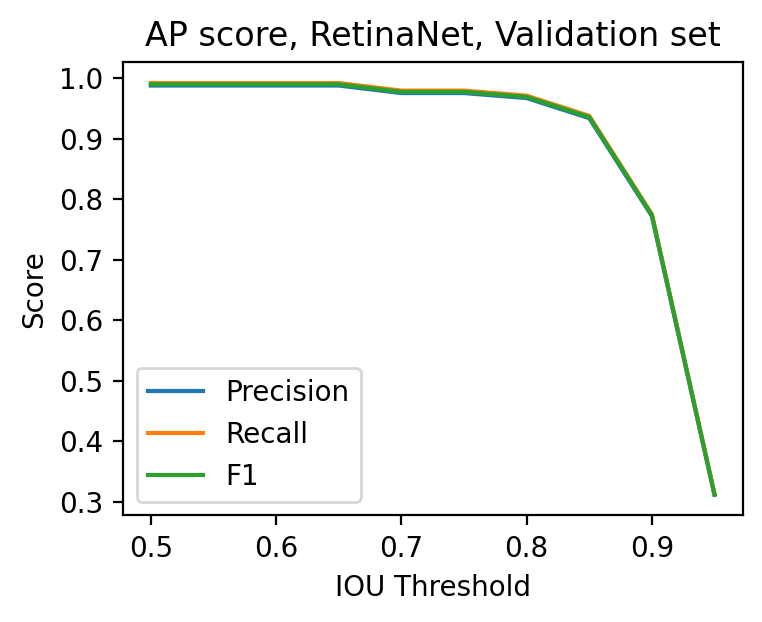

In [15]:
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(IOU_thres, precision_list)
plt.plot(IOU_thres, recall_list)
plt.plot(IOU_thres, f1_list)
plt.legend(['Precision', 'Recall', 'F1'])
plt.title('AP score, RetinaNet, Validation set')
plt.ylabel('Score')
plt.xlabel('IOU Threshold')


average_precision = np.average(precision_list)
average_recall = np.average(recall_list)
average_f1 = np.average(f1_list)

print('Avg. precision:', average_precision)
print('Avg. recall:   ', average_recall)
print('Avg. F1:       ', average_f1)